In [1]:
using DifferentialEquations, Optim, Plots, DataFrames, LinearAlgebra, CSV, Tables, Statistics, MuladdMacro

## Initialize

#### Functions
- `initialize`: sets all parameters and initial conditions, scaled by sex and BMI. Optional arguments allow optimization algorithms to change parameters during fitting process and manual fixing of parameters if needed.

In [2]:
"""
initial conditions for new thyrosim model
"""
function initialize(
    dial::Vector{Float64} = [1.0; 0.88; 1.0; 0.88],
    scale_Vp::Bool = false,
    height=1.70,
    weight=70,
    sex=true; #true = male, false = female,
    hashimoto::Bool=true,
    fitting_index::Vector = Int[],         # needed in fitting
    p_being_optimized::Vector = Float64[], # needed in fitting
    fixed_parameters::Vector{Tuple{Int, Float64}}, # (a, b) means fix p[a] at b 
    scale_plasma_ode::Bool = false,
    scale_slow_ode::Bool = false,
    scale_fast_ode::Bool = false,
    scale_allometric_exponent::Bool = false,
    scale_clearance_by_gender::Bool = true,
    )

    # Thyroid IC
    ic    = zeros(Float64, 25)
    ic[1] = 0.322114215761171
    ic[2] = 0.201296960359917
    ic[3] = 0.638967411907560
    ic[4] = 0.00663104034826483
    ic[5] = 0.0112595761822961
    ic[6] = 0.0652960640300348
    ic[7] = 1.78829584764370
    ic[8] = 7.05727560072869
    ic[9] = 7.05714474742141
    ic[10] = 0
    ic[11] = 0
    ic[12] = 0
    ic[13] = 0
    ic[14] = 3.34289716182018
    ic[15] = 3.69277248068433
    ic[16] = 3.87942133769244
    ic[17] = 3.90061903207543
    ic[18] = 3.77875734283571
    ic[19] = 3.55364471589659

    # Immune IC
    ic[20] = 320 # B-cells
    ic[21] = 80 # Plasma cells 
    ic[22] = 680 # CD4+ cells
    ic[23] = 5e9 # Cytokines
    ic[24] = 13 # FTS
    ic[25] = 240 # Antibodies

    # Parameter values
    p = zeros(Float64, 100)
    p[1] = 0.0027785399344 #S4 (fitted)
    p[2] = 8               #tau
    p[3] = 0.868           #k12
    p[4] = 0.108           #k13
    p[5] = 584             #k31free
    p[6] = 1503            #k21free
    p[7] = 0.000289        #A
    p[8] = 0.000214        #B
    p[9] = 0.000128        #C
    p[10] = -8.83*10^-6    #D
    p[11] = 0.88           #k4absorb; originally 0.881
    p[12] = 0.0189         #k02
    p[13] = 0.012101809339 #VmaxD1fast (fitted)
    p[14] = 2.85           #KmD1fast
    p[15] = 6.63*10^-4     #VmaxD1slow
    p[16] = 95             #KmD1slow
    p[17] = 0.00074619     #VmaxD2slow
    p[18] = 0.075          #KmD2slow
    p[19] = 3.3572*10^-4   #S3
    p[20] = 5.37           #k45
    p[21] = 0.0689         #k46
    p[22] = 127            #k64free
    p[23] = 2043           #k54free
    p[24] = 0.00395        #a
    p[25] = 0.00185        #b
    p[26] = 0.00061        #c
    p[27] = -0.000505      #d
    p[28] = 0.88           #k3absorb
    p[29] = 0.184972339613 #k05 (fitted)
    p[30] = 450            #Bzero (fixed so max TSH is about 1000)
    p[31] = 219.7085301388 #Azero (fitted)
    p[32] = 0              #Amax (set to 0 because 1976 weeke says hypothyroid patients should have no oscillations)
    p[33] = -3.71          #phi
    p[34] = 0.53           #kdegTSH-HYPO
    p[35] = 0.226          #VmaxTSH (originally it's 0.037 but this is probably a typo because eq4 of 2010 eigenberg it not a real hill function)
    p[36] = 23             #K50TSH
    p[37] = 0.058786935033 #k3 (fitted)
    p[38] = 0.29           #T4P-EU
    p[39] = 0.006          #T3P-EU
    p[40] = 0.037          #KdegT3B
    p[41] = 0.0034         #KLAG-HYPO
    p[42] = 5              #KLAG
    p[43] = 1.3            #k4dissolve
    p[44] = 0.12           #k4excrete; originally 0.119 (change with dial 2)
    p[45] = 1.78           #k3dissolve
    p[46] = 0.12           #k3excrete; originally 0.118 (change with dial 4)
    p[47] = 3.2            #Vp
    p[48] = 5.2            #VTSH

    #parameters for hill functions in f_circ and SRtsh
    p[49] = 3.001011022378 #K_circ (fitted)
    p[50] = 3.094711690204 #K_SR_tsh (fitted)
    p[51] = 5.674773816316 #n, hill exponent in f_circ (fitted)
    p[52] = 6.290803221796 #m, hill exponent in SR_tsh (fitted)
    p[53] = 8.498343729591 #K_f4 for f4 (fitted)
    p[54] = 14.36664496926 #l, hill exponent for f4 (fitted)

    # p[55] = 0.0 # T4 oral dose
    # p[56] = 0.0 # T3 oral dose

    # dial parameters 
    p[57] = dial[1] # controls T4 secretion rate
    p[58] = dial[2] # controls T4 excretion rate
    p[59] = dial[3] # controls T3 secretion rate
    p[60] = dial[4] # controls T3 excretion rate

    # variance parameters for T4/T3/TSH and schneider error (these are used only for parameter estimation!)
    p[61] = 5.003761571969437   # σ for T4 in Blakesley (fixed to reasonable value before fitting)
    p[62] = 0.11122955089297369 # σ for T3 Blakesley and Jonklaas (fixed to reasonable value before fitting)
    p[63] = 0.4                 # σ for TSH in Blakesley and Jonklaas (fixed to reasonable value before fitting)
    p[64] = 0.1                 # σ for FT4 in Jonklaas (fixed to reasonable value before fitting)

    # Blakesley reference BMI
    p[65] = 21.82854404275587 # (male, fitted)
    p[66] = 22.99050845201536 # w / h^2 (female, fitted)

    # Vtsh scaling factor
    p[67] = 1.0 

    # extra parameter
    # p[68] = 22.5 # w / h^2 (female)

    # Volume scaling ratio
    p[69] = 1.0 # Plasma volume ratio
    p[70] = -1.0 # Plasma volume (forgot what this is supposed to represent)
    p[71] = 1.0 # allometric exponent for plasma volume

    # slow compartment scaling ratio
    p[72] = 1.0 # fat-free constant
    p[73] = 0.0 # fat constant
    p[74] = 1.0 # scaling ratio for slow compartment

    # fast compartment scaling ratio
    p[75] = 1.0

    # allometric exponent for k05 
    p[76] = 0.75 # for male (fixed)
    p[77] = 0.75 # for female (fixed, 0.75 works well)

    # ref height for male and female
    p[78] = 1.7608716659237555 # (fitted)
    p[79] = 1.6696106891941103 # (fitted)

    # clearance scale (male / female)
    p[80] = 1.0499391485135692 # male clearance (fitted)

    # infusion parameters
    p[81] = 0.0 # T4 infusion
    p[82] = 0.0 # T3 infusion

    # Immune Parameters (changed to hour)
    p[83] = 180.0e-2 # ΦB B-cell activation rate, will probably be lower due to T3 term p[15]
    p[84] = 120.0e-1 # ΦP Plasma cell transformation rate
    p[85] = 120.0e3 # ΦT CD4+ activation rate
    p[86] = 3060.0e5 # ΦC Cytokine production rate
    p[87] = 1.2e1 # ΦFTS relative growth rate of FTS
    if !hashimoto 
        p[88] = 0 # ΦAb combined antibody production rate
    else
        p[88] = 120.02e-2
    end
    p[89] = 300.0e-3 # δB B-cell death rate
    p[90] = 60.0e-1 # δP Plasma cell death rate
    p[91] = 150.0e-2 # δT CD4+ cell death rate
    p[92] = 72.0e3  # δC Cytokine degredation rate
    p[93] = 18.0e-3 # δFTS Functional thyroid destruction rate
    p[94] = 104.0e1 # δAb Blood Ab degredation rate
    p[95] = 1080.0e5 # τB B-cell cytokine binding activation threshold
    p[96] = 120.0e6 # τT CD4+ T-cell cytokine binding activation threshold
    p[97] = 60.0e5 # σB FT4 B-cell stimulation NOTE: NEED TO FIT and CHANGE - try changing this a lot
    p[98] = 60.0e3 # σT FT4 T-cell stimulation
    p[99] = 546.0e-4 # N CD4+ T-cell inhibition rate
    p[100] = 13.0 # FTS0  Euthyroid FTS

    # change fitting parameters
    if length(fitting_index) > 0
        p[fitting_index] .= p_being_optimized
    end

    clearance_allometric_exp = sex ? p[76] : p[77]
    ref_weight = (p[65] * p[78]^2 + p[66] * p[79]^2) / 2
    p[29] *= (weight / ref_weight)^clearance_allometric_exp
    sex && (p[29] *= p[80]) # scale male k05 by prefactor

    # fix parameters declared by users
    for (a, b) in fixed_parameters
        p[a] = b
    end

    return ic, p
end



initialize

## ODEs

#### Functions:

- `thyrosim`: ODE model. First 19 terms are for original thyrosim. Terms 20-25 are the immune submodel.
- `find_patient_ic!`: simulates 1 month to determine steady state initial conditions for particular patient before running main simulation.

In [3]:
"""
ODEs for latest thyrosim model. 
"""
function thyrosim(dq, q, p, t)
    kdelay = 5/8

    # scaling the mass/concentration of compartments
    plasma_volume_ratio = p[69]^p[71]
    slow_volume_ratio = p[74]^p[71]
    fast_volume_ratio = p[75]^p[71]

    # scale comparment sizes
    q1 = q[1] * 1 / p[69]
    q2 = q[2] * 1 / p[75]
    q3 = q[3] * 1 / p[74]
    q4 = q[4] * 1 / p[69]
    q5 = q[5] * 1 / p[75]
    q6 = q[6] * 1 / p[74]
    q7 = q[7] * 1 / p[69]
    RTF = q[24] / p[100] 

    # Auxillary equations
    q4F = (p[24]+ p[25] * q1 + p[26] * q1^2 + p[27] * q1^3) * q4 #FT3p
    q1F = (p[7] + p[8] * q1 + p[9] * q1^2 + p[10] * q1^3) * q1  #FT4p
    SR3 = RTF * (p[19] * p[59] * q[19])                                        #Brain delay (dial 3)
    SR4 = RTF * (p[1] * p[57] * q[19])                                         #Brain delay (dial 1)
    fCIRC = q[9]^p[51] / (q[9]^p[51] + p[49]^p[51])
    SRTSH = (p[30]+p[31]*fCIRC*sin(pi/12*t-p[33]))*(p[50]^p[52]/(p[50]^p[52] + q[9]^p[52]))
    fdegTSH = p[34] + p[35] / (p[36] + q7)
    fLAG = p[41] + 2*q[8]^11 / (p[42]^11 + q[8]^11)
    f4 = p[37]*(1 + 5*(p[53]^p[54]) / (p[53]^p[54]+q[8]^p[54]))
    NL = p[13] / (p[14] + q2)

    # Thyroid ODEs
    dq[1]  = p[81] + (SR4 + p[3] * q2 + p[4] * q3 - (p[5] + p[6]) * q1F) * plasma_volume_ratio + p[11] * q[11] #T4dot (need to remove u1)
    dq[2]  = (p[6] * q1F - (p[3] + p[12] + NL) * q2) * fast_volume_ratio                                    #T4fast
    dq[3]  = (p[5] * q1F -(p[4] + p[15] / (p[16] + q3) + p[17] /(p[18] + q3)) * q3) * slow_volume_ratio  #T4slow
    dq[4]  = p[82] + (SR3 + p[20] * q5 + p[21] * q6 - (p[22] + p[23]) * q4F) * plasma_volume_ratio + p[28] * q[13] #T3pdot
    dq[5]  = (p[23] * q4F + NL * q2 - (p[20] + p[29]) * q5) * fast_volume_ratio                         #T3fast
    dq[6]  = (p[22] * q4F + p[15] * q3 / (p[16] + q3) + p[17] * q3 / (p[18] + q3) -(p[21])*q6) * slow_volume_ratio #T3slow
    dq[7]  = (SRTSH - fdegTSH * q7) * plasma_volume_ratio                                           #TSHp
    dq[8]  = f4 / p[38] * q1 + p[37] / p[39] * q4 - p[40] * q[8]          #T3B
    dq[9]  = fLAG * (q[8] - q[9])                                             #T3B LAG
    dq[10] = -p[43] * q[10]                                                   #T4PILLdot
    dq[11] =  p[43] * q[10] - (p[44] * p[58]+ p[11]) * q[11]                  #T4GUTdot: note p[44] * p[58] = p[44] * dial[2] = k4excrete
    dq[12] = -p[45] * q[12]                                                   #T3PILLdot
    dq[13] =  p[45] * q[12] - (p[46] * p[60] + p[28]) * q[13]                 #T3GUTdot: note p[46] * p[60] = p[46] * dial[4] = k3excrete

    # Delay ODEs
    dq[14] = kdelay * (q7 - q[14]) 
    dq[15] = kdelay * (q[14] - q[15])                                         #delay2
    dq[16] = kdelay * (q[15] - q[16])                                         #delay3
    dq[17] = kdelay * (q[16] - q[17])                                         #delay4
    dq[18] = kdelay * (q[17] - q[18])                                         #delay5
    dq[19] = kdelay * (q[18] - q[19])                                         #delay6

    # Immune ODEs: We do have FT4 acting on B and T cells... nice!

    dq[20] = p[83]*(q[23]/(q[23]+p[95]))*q[22]+(p[97]*q1F)-(p[89]+p[84])*q[20] # Bdot -- changed to T4 stimulation
    dq[21] = p[84]*q[20]-p[90]*q[21] # Pdot
    dq[22] = p[85]*q[24]+p[98]*q1F-p[99]*(q[23]/(q[23]+p[96]))*q[22]-p[91]*q[22] # Tdot
    dq[23] = p[86]*q[22]-p[92]*q[23] # Cdot
    dq[24] = (p[87]*((q7/q[24])*p[100])-p[93]*(q[24])*q[25])/10000 #p[87]*((q7/q[24])*p[100])-p[93]*(q[24]/p[100])*q[25] # FTSdot MODIFIED
    dq[25] = (p[88]*q[21]-q[25]*(p[94]+p[93]*q[24])) # Abdot
end

"""
Find initial conditions from approximate steady state solution. 

This function runs a Thyrosim simulation for 30 days and sets the initial 
contidion `ic` to the ending values for each compartment.
"""
function find_patient_ic!(ic, p, days, model = thyrosim)
    tspan = (0.0, 24.0 * days)
    prob = ODEProblem(model, ic, tspan, p)
    sol = solve(prob)
    ic .= sol[end]
end


find_patient_ic!

### Conversion Functions

In [4]:
## CHECK BELOW!

"""
Converts TT4 (μmol) to FT4 (μg/dL) using Thyrosim's internal 4th order polynomial
"""
function FT4(TT4::Float64)
    return (0.000289 + (0.000214 * TT4) + (0.000128 * TT4^2) - (8.83e-6 * TT4^3)) * TT4 * 24281.25 * .45  # Convert from TT4 to FT4 then from μmol FT4 to μg/dL FT4 via scaling factor 
end

"""
Converts TT3 (μmol) to FT3 (μmol) using Thyrosim's internal 4th order polynomial
"""
function FT3(TT3::Float64)
    return (0.00395 + (0.00185 * TT3) + (0.000610 * TT3^2) - (-0.000505 * TT3^3)) * TT3 * 2830400.35 * 5
end

FT3

## Simulation Functions

In [5]:
function simulate(
    h::Real, # units meters
    w::Real, # units kg
    sex::Bool, # true = male, false = female
    dose_df::DataFrame;
    days::Int=30, 
    dial=[1.0; 0.88; 1.0; 0.88],
    hashimoto::Bool=false,
    T4dose::Real=0.0, # mcgs
    T3dose::Real=0.0, # mcgs
    dosing_interval::Real = 24,
    warmup::Bool = true,
    fitting_index=Int[],
    parameters=Float64[],
    fixed_parameters=Tuple{Int64,Float64}[],
    scale_plasma_ode=false,
    scale_slow_ode=false,
    scale_fast_ode=false,
    scale_allometric_exponent = false,
    scale_clearance_by_gender = false,
    )

    dose_df_times = dose_df.t.*24

    function add_dose!(integrator)
        try
            integrator.u[10] += dose_df.dose[findfirst(==(integrator.t), dose_df_times)]/777
        catch
            integrator.u[10] += 0
        end
    end

    cbk = PeriodicCallback(add_dose!, dosing_interval) 

    # initialize thyrosim parameters
    ic, p = initialize(dial, true, h, w, sex, 
        fitting_index=fitting_index, p_being_optimized=parameters,
        fixed_parameters=fixed_parameters, hashimoto=hashimoto,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode,
        scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
    p[fitting_index] .= parameters

    # run simulation for 30 days to get approximate steady state conditions
    # this assumes healthy patient without dose
    warmup && find_patient_ic!(ic, p, 30) 

    # setup daily dosing and fitting parameters 
    p[55] = T4dose / 777.0 # daily dose
    p[56] = T3dose / 651.0 # daily dose
    p[57:60] .= dial #set dial

    # solve and return ode solution
    prob = ODEProblem(thyrosim,ic,(0.0, 24days),p,callback=cbk)
    return solve(prob)
end

function output_plot(sol; title::AbstractString = "Thyrosim simulation", automargins::Bool=true)

    # parameters to adjust figure limits
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 2.5, 500, 10
    T4 = (FT4.(sol[1, :]))
    T3 = (FT3.(sol[4, :]))
    TSH = 5.6 * sol[7, :] / p[48]
    Bcell = sol[20, :]./1000 # convert from cell/mL to cell/μL
    Pcell = sol[21, :]./1000 # convert from cell/mL to cell/μL
    Tcell =  sol[22, :]./1000 # convert from cell/mL to cell/μL
    Lymphocytes = (Bcell + Pcell + Tcell)
    TPOAb = sol[25, :]
    T4T3Ranges = [[0.9, 2.3], [260, 480]]

    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), label="",
       ylabel="FT4 (ng/dL)", title=title)
    p1 = hline!(T4T3Ranges[1], label= "")
    
    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), label="", 
       ylabel="FT3 (pg/dL)")
    p2 = hline!(T4T3Ranges[2], label= "")
    
    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), label="",
       ylabel="TSH (mU/L)")
    p3 = hline!([0.45, 4.5], label= "")

    p4 = plot(sol.t / 24.0, Lymphocytes,
     ylabel="Lymphocytes (cell/μL)", label="")
    p4 = plot!(sol.t /24.0, Bcell, label = "B-Cells")
    p4 = plot!(sol.t /24.0, Tcell, label = "T-Cells")
    p4 = plot!(sol.t /24.0, Pcell, label = "Plasma Cells")

    p5 = plot(sol.t / 24.0, TPOAb, ylabel="TPOAb (IU/mL)", label="")
    
    plot!(size=(900,900))
    p_main = plot!(p1, p2, p3, p4, p5, layout=(5,1))
    plot(p_main)

end

output_plot (generic function with 1 method)

## Testing Plots

### Data Import

In [6]:
function plot_patient(patient; title::String="Patient Labs")
    labs = patient[1]
    meds = patient[2]

    T4T3Labels = ["FT4 (ng/dL)", "FT3 (pg/dL)"]
    T4T3Ranges = [[0.9, 2.3], [260, 480]]
    xlims = (min(minimum(labs.t), minimum(meds.t)), max(maximum(labs.t), maximum(meds.t)))

    t = labs.t
    
    p1 = plot(t, labs.T4, label="T4", xlim=xlims, ylabel=T4T3Labels[1])
    any(meds.dose .!= 0) && (p1 = plot!(twinx(), meds.dose, xlim=xlims, ylabel="Levothyroxine (mcg/day)", label="Dose", color = "red", xticks=:none))
    p1 = hline!(T4T3Ranges[1], label= "")
    p1 = scatter!(t, labs.T4, alpha = 0.3, label="")
    
    p2 = plot(t, labs.T3, label="", xlim=xlims, ylabel=T4T3Labels[2])
    p2 = hline!(T4T3Ranges[2], label= "")
    p2 = scatter!(t, labs.T3, alpha = 0.3, label="")
    
    p3 = plot(t, labs.TSH, label="", xlim=xlims, ylabel="TSH (mU/L)")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t, labs.TSH, alpha = 0.3)

    p4 = plot(t, labs.Lymphocytes, xlim=xlims, ylabel="Lymphocytes (cell/μL)", label="")
    p4 = scatter!(t, labs.Lymphocytes, alpha = 1, label="")

    p5 = plot(t, labs.Ab, ylabel="TPOAb (IU/mL)", xlim=xlims, xlabel="time [days]", label="")
    p5 = scatter!(t, labs.Ab, alpha = 1, label="")

    layout = @layout [a b ; c ; d e]
    plot!(size=(900,900))
    p_main = plot(p1, p2, p3, p4, p5, layout=layout)
    p_main[:plot_title] = title
    plot(p_main)

end

plot_patient (generic function with 1 method)

### Basic Test

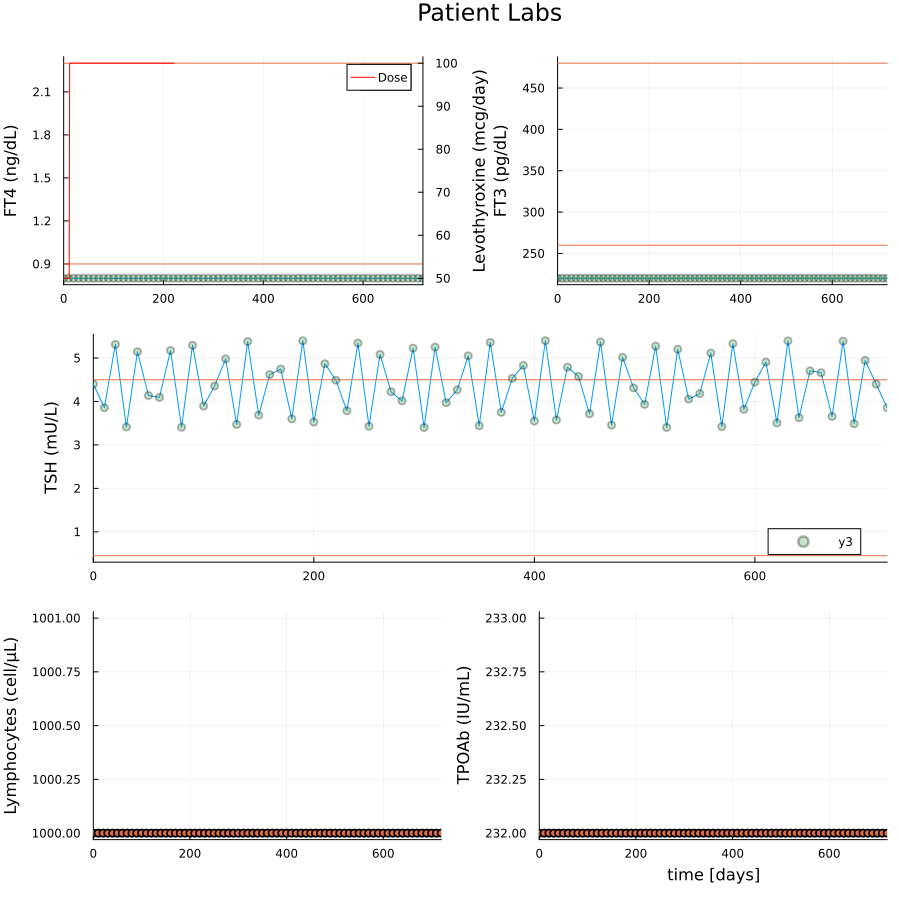

In [7]:
# All doses need to be normalized to 1 per day (ok due to halflife of T4 anyway...)
dose_df = DataFrame(CSV.File("C:/Users/Aidan/Documents/GitHub/BioCyb/ThyrosimIM2/data/example_dose.csv"))
labs_df = DataFrame(CSV.File("C:/Users/Aidan/Documents/GitHub/BioCyb/ThyrosimIM2/data/example_labs.csv"))
patient = [labs_df, dose_df];

plot_patient(patient)

In [8]:
sol = simulate(1.63, 75, true, dose_df, warmup = true, days = 365, hashimoto=true);

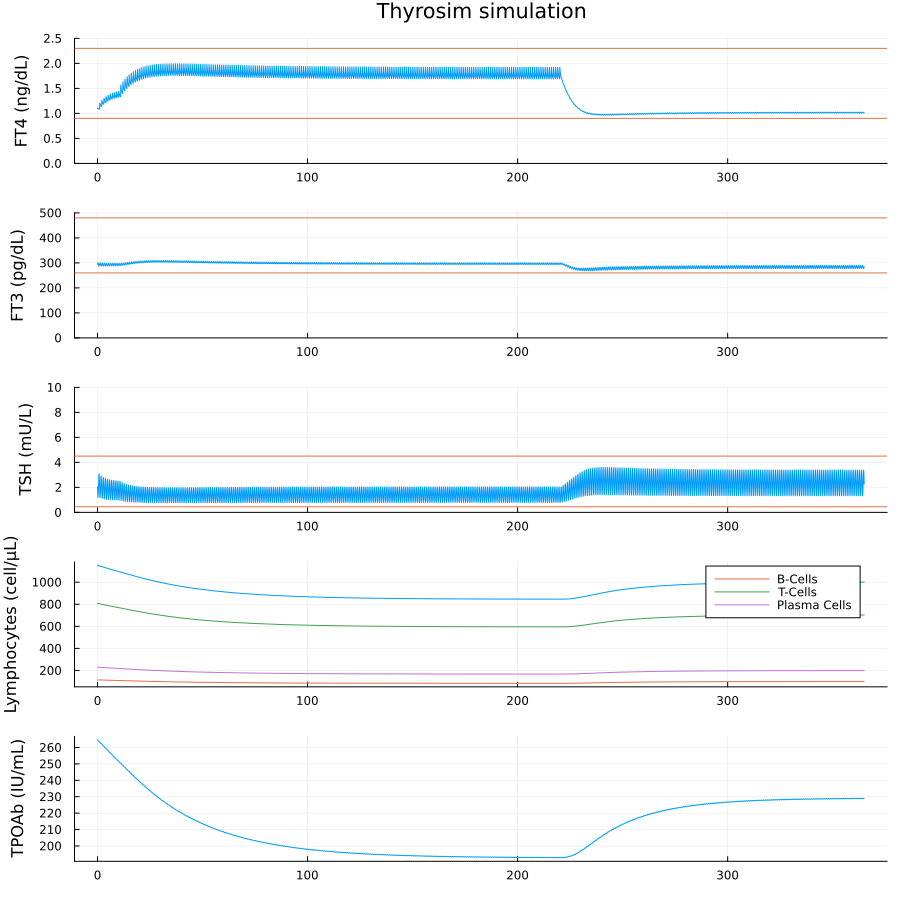

In [9]:
output_plot(sol)

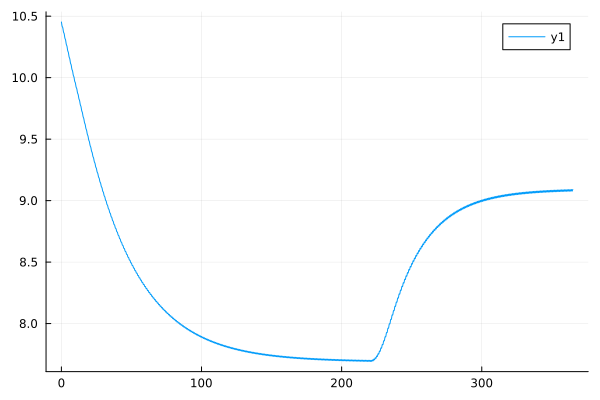

In [10]:
plot(sol.t./24, sol[24, :])

## Fitting Functions

In [115]:
import NaNMath # handles log of negative number that can occur due to adaptive ODE solvers

function log_lsq_loss(sol, time, data)
    data_columns = names(data)[2:6] # this selects T4, T3, TSH, Lymphocytes, Ab
    sol_indicies = [[1],[4],[7],[20,21,22],[25]] # indicies for T4, T3, TSH, Lymphocytes, Ab
    loss_vector = [0.0,0.0,0.0,0.0,0.0] # loss for T4,T3, TSH, Lymphocytes, Ab respectivley
    for (i, column) in enumerate(data_columns)
        #out = true
        if any(!ismissing, data[!, column])
            μ = mean(skipmissing(data[!, column]))
            for (j, t) in enumerate(time)
                datapoint = data[!, column][j]
                if ismissing(datapoint)
                    loss_vector[i] = loss_vector[i]
                else
                    predicted = 0
                    if column == "T4"
                        predicted = FT4((sol(t)[sol_indicies[i]])[1])
                        #out && println("FT4 at t = 0: $(predicted). Actual: $(datapoint)"); out = false
                        loss_vector[i]+= ((log10(predicted^2) - log10(datapoint^2))/log10(μ^2))^2
                    elseif column == "T3"
                        predicted = FT3((sol(t)[sol_indicies[i]])[1])
                        #out && println("FT3 at t = 0: $(predicted). Actual: $(datapoint)"); out = false
                        loss_vector[i]+= ((log10(predicted^2) - log10(datapoint^2))/log10(μ^2))^2
                    else
                        for state_variable in sol_indicies[i]
                            predicted += sol(t)[state_variable][1]
                        end
                        loss_vector[i] += ((log10(predicted^2) - log10(datapoint^2))/log10(μ^2))^2
                    end
                end
            end
        else
            loss_vector[i] += 0
        end
    end
    return loss_vector
end

log_lsq_loss (generic function with 1 method)

In [116]:
function objective(
    free_parameters,
    labs_df,
    days,
    fitting_index,
    lb,
    ub)

    for (i, parameter) in enumerate(free_parameters[1:end-5])
        if !(lb[i] ≤ parameter ≤ ub[i])
            # println("Parameter $i with value $parameter was out of bounds $(lb[i]) -- $(ub[i]).")
            return Inf
        end
    end

    time = labs_df.t
    sol = simulate(1.7, 75.0, false, dose_df, warmup = true, days=days, hashimoto=true, fitting_index=fitting_index, parameters=free_parameters)
    loss = sum(log_lsq_loss(sol, time, labs_df)) 

    return loss
end

function fit(h::Real, w::Real, sex::Bool, patient, fitting_index, lb, ub,
    optimization_routine, time_limit::Real, iterations::Real, hashimoto)

    initial_conditions, parameters = initialize([1.0; 0.88; 1.0; 0.88], true, h, w, sex,
        fitting_index=[], p_being_optimized=[],
        fixed_parameters=Tuple{Int64,Float64}[], hashimoto=hashimoto,
        scale_plasma_ode=false, scale_slow_ode=false,
        scale_fast_ode=false,
        scale_allometric_exponent=false,
        scale_clearance_by_gender=true)

    free_params_initial = parameters[fitting_index]

    labs_df = patient[1]
    dose_df = patient[2]
    days = labs_df.t[end]

    solution = optimize(free_parameters -> objective(free_parameters, labs_df, days, fitting_index), 
    free_params_initial, optimization_routine, 
    Optim.Options(time_limit = time_limit, iterations = iterations, g_tol=1e-15,
    show_trace = false, allow_f_increases=true))

    return solution
end

fit (generic function with 5 methods)

In [117]:
free_indicies = Int.(vcat([1,11,19,31,34,50,57,58,59,60],collect(83:100)))
lb = zeros(size(free_indicies)[1])
ub = 1e8*ones(size(free_indicies)[1]);

In [118]:
fit(1.7, 75.0, false, patient, free_indicies, lb, ub, NelderMead(), 100.0, 10000, true)


DomainError: DomainError with -0.12416920037492632:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.